In [3]:
from plot_statistics import *


Stepper-Adaptive: 200 generations
10000 evaluations, 582 cache hits, 2273 invalid, 0 constraints violated, avg evaluation time: 8.41 s
runtime 23.36 h, evaluation time 93.19 h (this run 88.65 h)

                          Average   Median     Std    Worst     Best Best run
0                Fitness      1.2     1.63    0.78    -0.18      2.0        1
1     Final Test Fitness     0.97     1.26    0.94    -1.18     1.93        1
2   Number of Parameters  17022.0  15564.0  5351.0  27994.0  10847.0        2
3             Error Rate     1.66     1.32    0.71     2.99     0.79        1
4    Training Error Rate     1.47     1.28    0.57     2.38     0.63        1
5  Final Test Error Rate     1.89     1.73    0.77     3.37     0.94        1


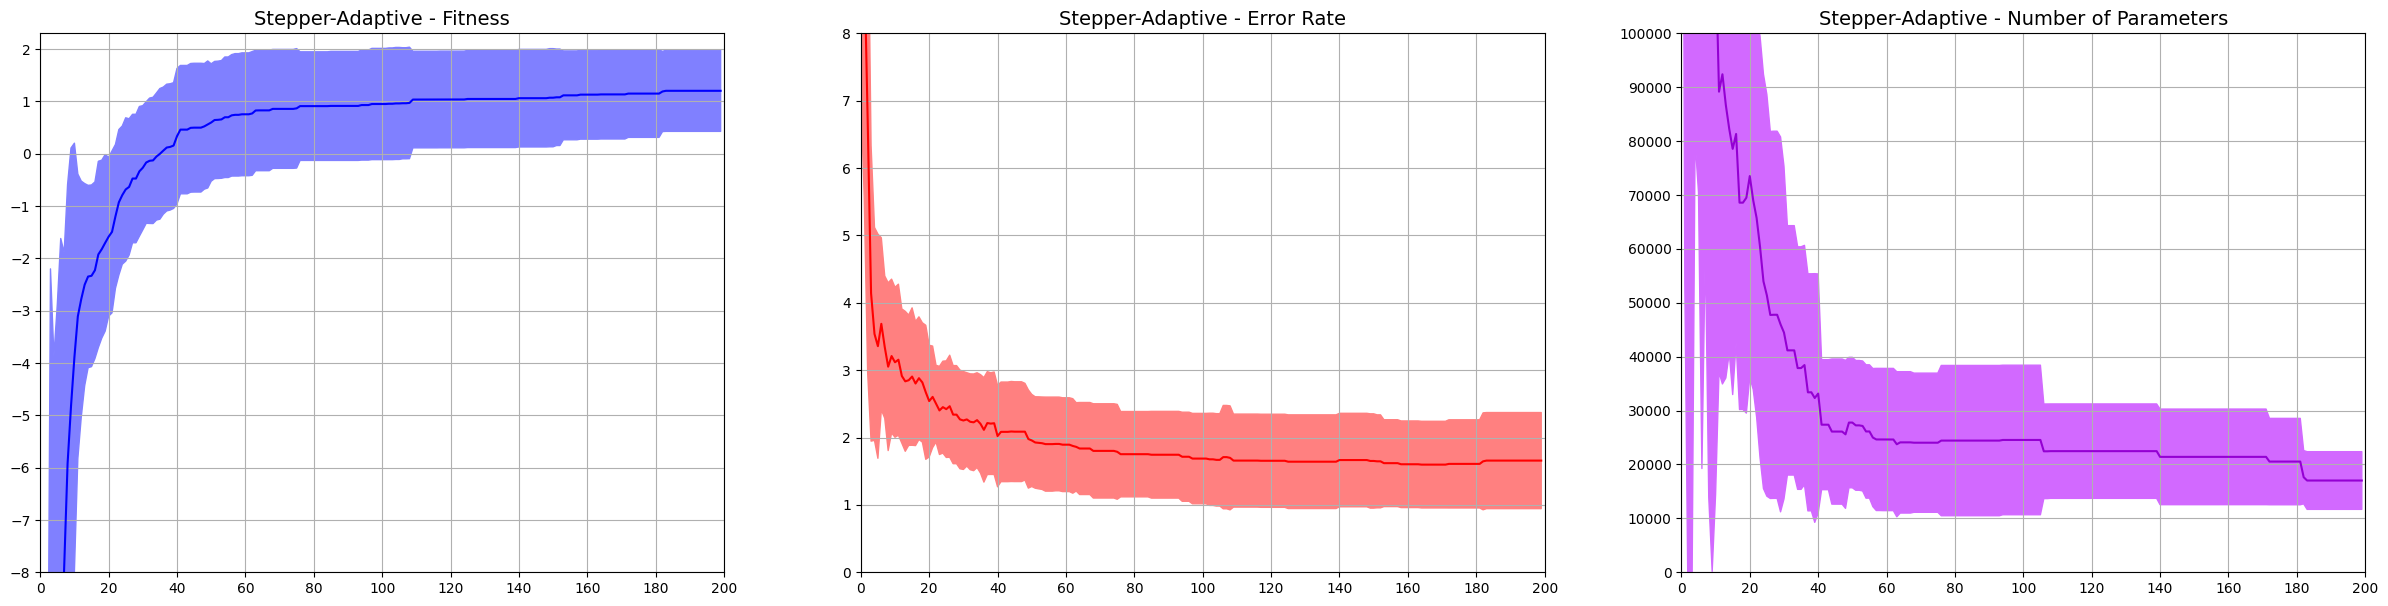

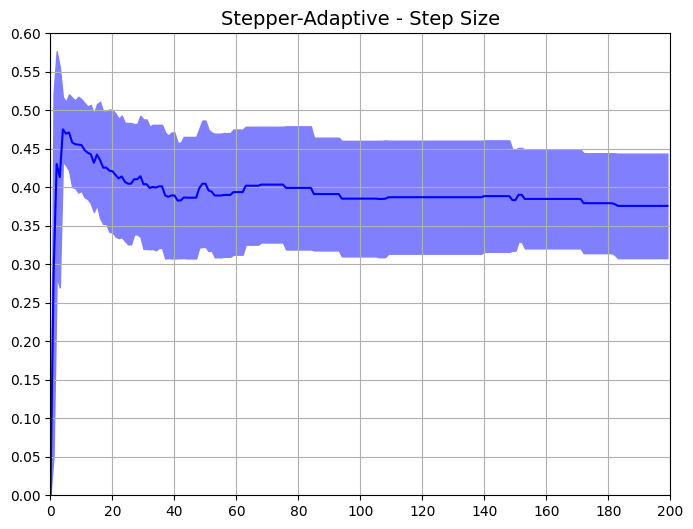

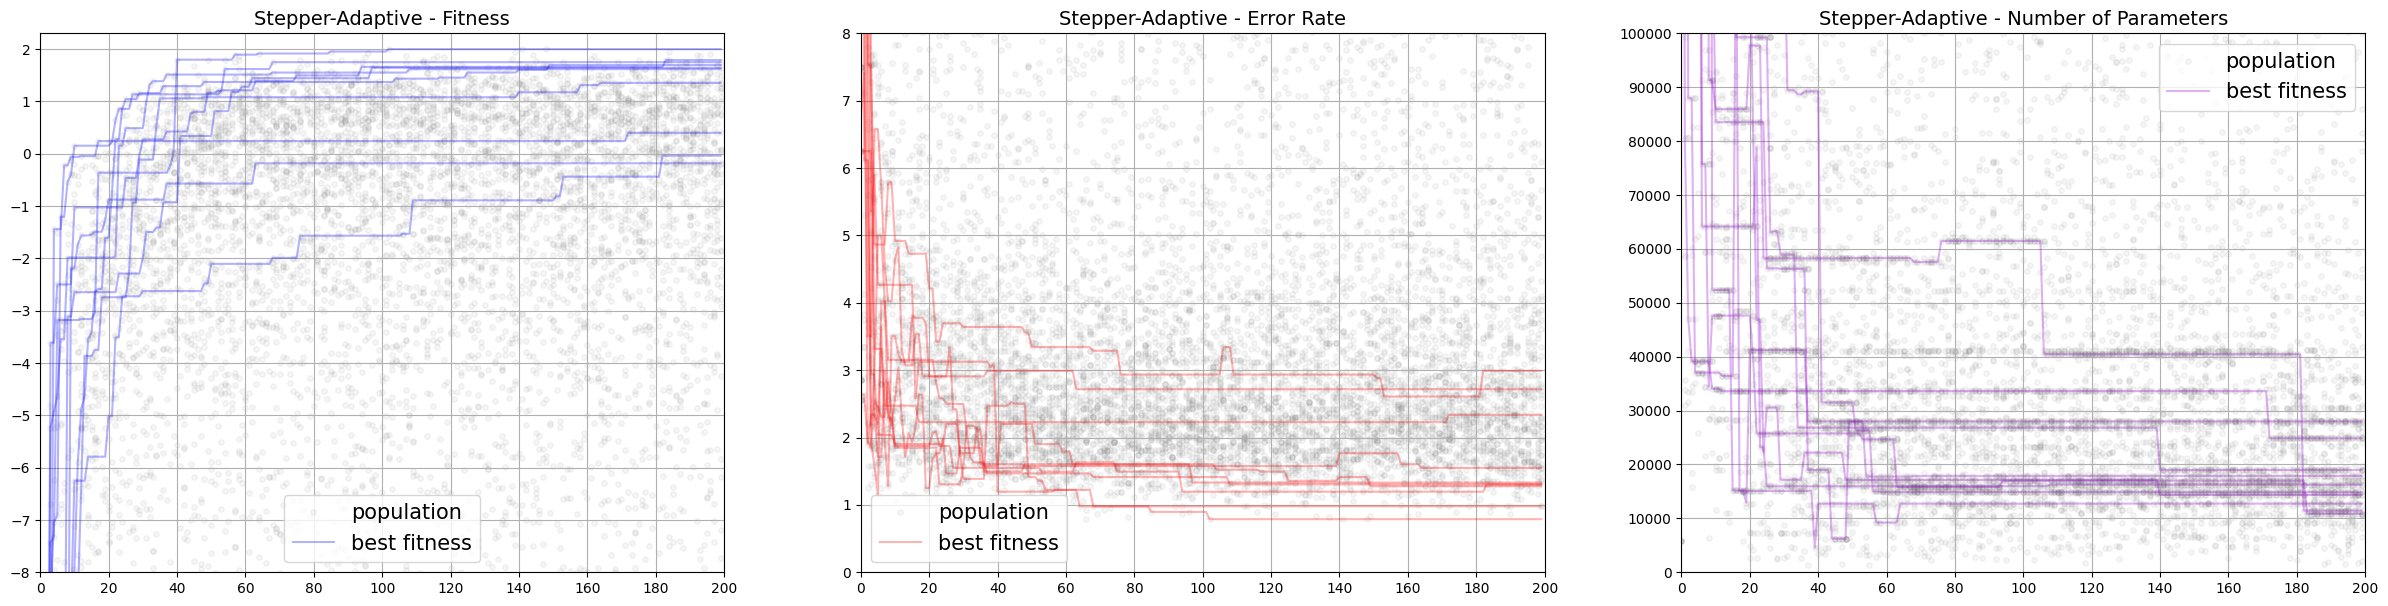

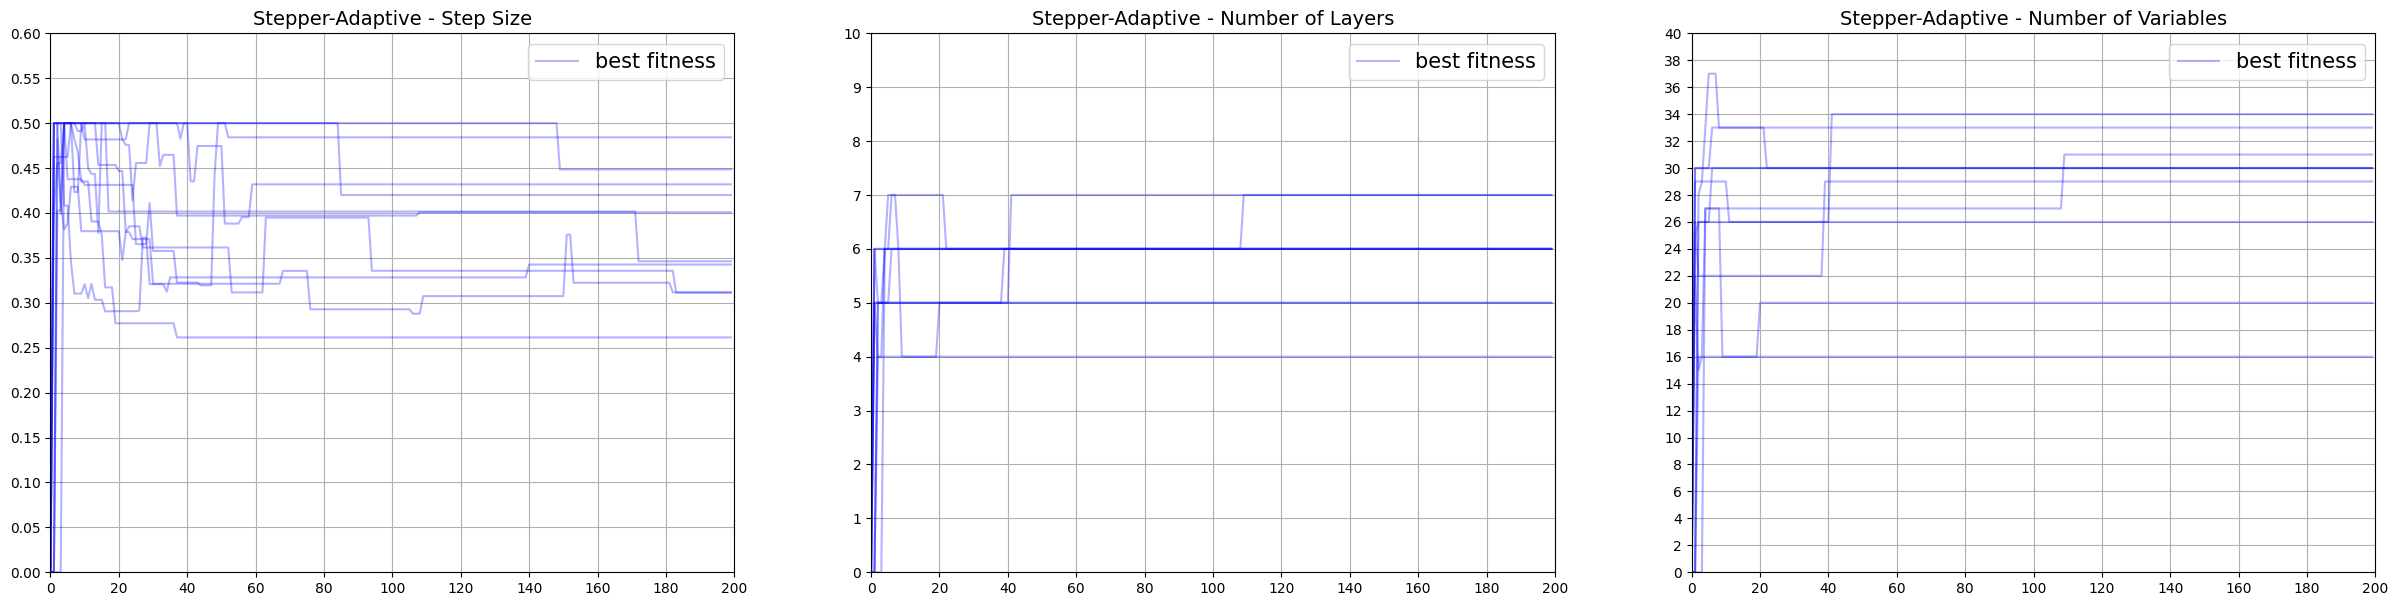

Plots for best run #1


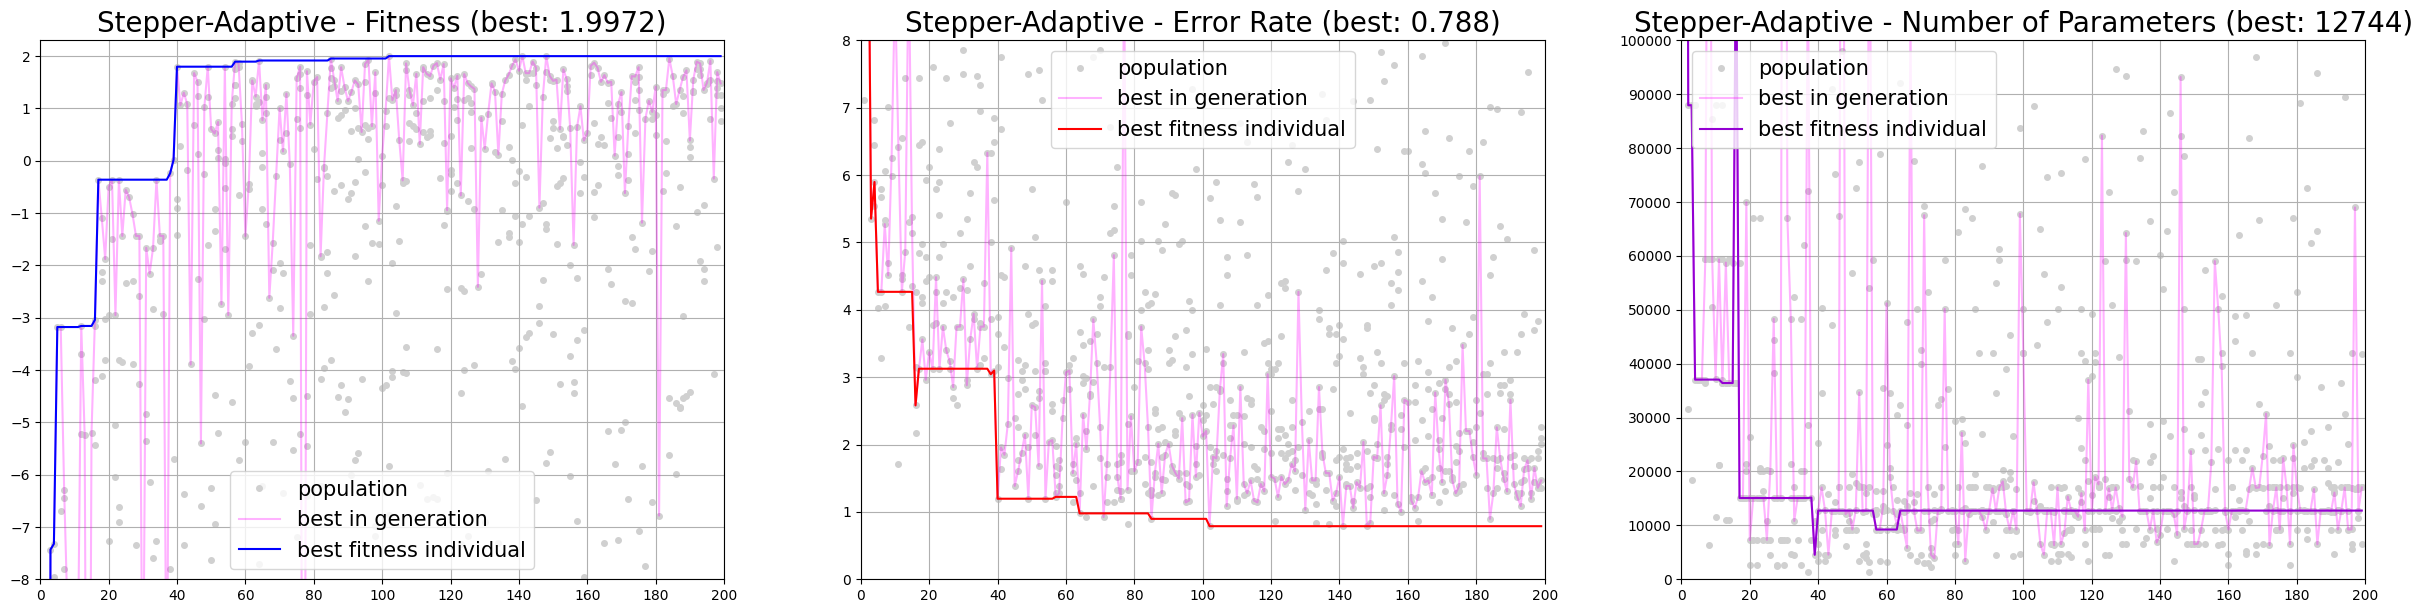

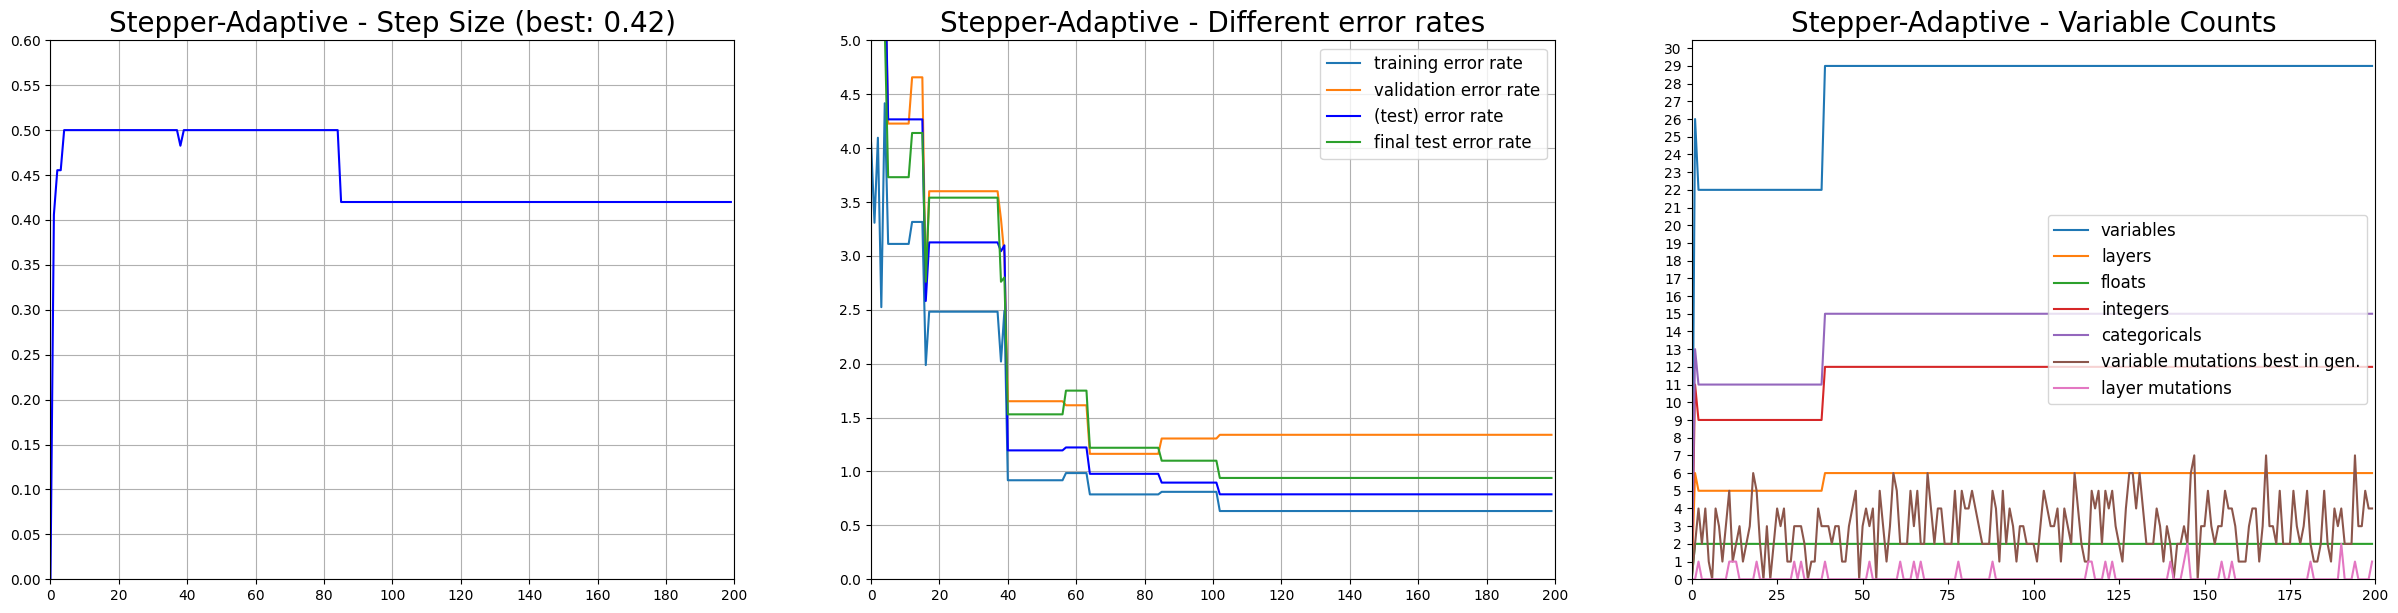

In [4]:
experiment_path = 'D:/experiments/'
# experiment_name = 'Random Search'
# experiment_name = 'F-DENSER'
# experiment_name = 'Stepper-Decay'
experiment_name = 'Stepper-Adaptive'

stats = load_stats(experiment_name, experiment_path)
print_statistics(stats, experiment_name)
do_all_plots(stats, experiment_name, plot_best_run=True, group_pictures=True)

In [5]:
experiment_path = 'D:/experiments.NAS_PAPER/'
experiment_name = 'Random Search'
stats = load_stats(experiment_name, experiment_path)
print_statistics(stats, experiment_name)

experiment_name = 'F-DENSER'
stats = load_stats(experiment_name, experiment_path)
print_statistics(stats, experiment_name)

experiment_name = 'Stepper-decay'
stats = load_stats(experiment_name, experiment_path)
print_statistics(stats, experiment_name)

experiment_name = 'Stepper-adaptive'
stats = load_stats(experiment_name, experiment_path)
print_statistics(stats, experiment_name)


Random Search: 200 generations
20000 evaluations, 44 cache hits, 5640 invalid, -1 constraints violated, avg evaluation time: 11.39 s
runtime 63.25 h, evaluation time 59.08 h (this run 58.95 h)

                          Average   Median      Std     Worst     Best  \
0                Fitness    -1.38     -1.4     1.42     -4.13     0.68   
1     Final Test Fitness    -1.38    -1.42     1.35      -4.9     0.57   
2   Number of Parameters  73669.0  71037.0  37066.0  177546.0  17173.0   
3             Error Rate     2.41     2.31     0.71      4.06     1.57   
4    Training Error Rate     1.71     1.43     0.88      4.56     0.75   
5  Final Test Error Rate     2.41     2.27     0.67      4.29     1.73   

  Best run  
0       16  
1       11  
2       11  
3        3  
4        0  
5        9  

F-DENSER: 200 generations
20000 evaluations, 5563 cache hits, 2375 invalid, -1 constraints violated, avg evaluation time: 7.41 s
runtime 41.15 h, evaluation time 53.18 h (this run 40.95 h)

    


Stepper-Adaptive: 200 generations
20000 evaluations, 964 cache hits, 1683 invalid, -1 constraints violated, avg evaluation time: 8.67 s
runtime 48.18 h, evaluation time 49.64 h (this run 47.74 h)

                          Average   Median     Std    Worst     Best Best run
0                Fitness     1.31     1.34    0.41     0.46     1.96       14
1     Final Test Fitness     1.13     1.33    0.58    -0.17     1.78       14
2   Number of Parameters  18077.0  15291.0  7287.0  35164.0  10530.0        2
3             Error Rate     1.59     1.51    0.39     2.57      1.0       14
4    Training Error Rate      1.4     1.41    0.45     2.59     0.67        9
5  Final Test Error Rate     1.79     1.68    0.44     2.87     1.31       14


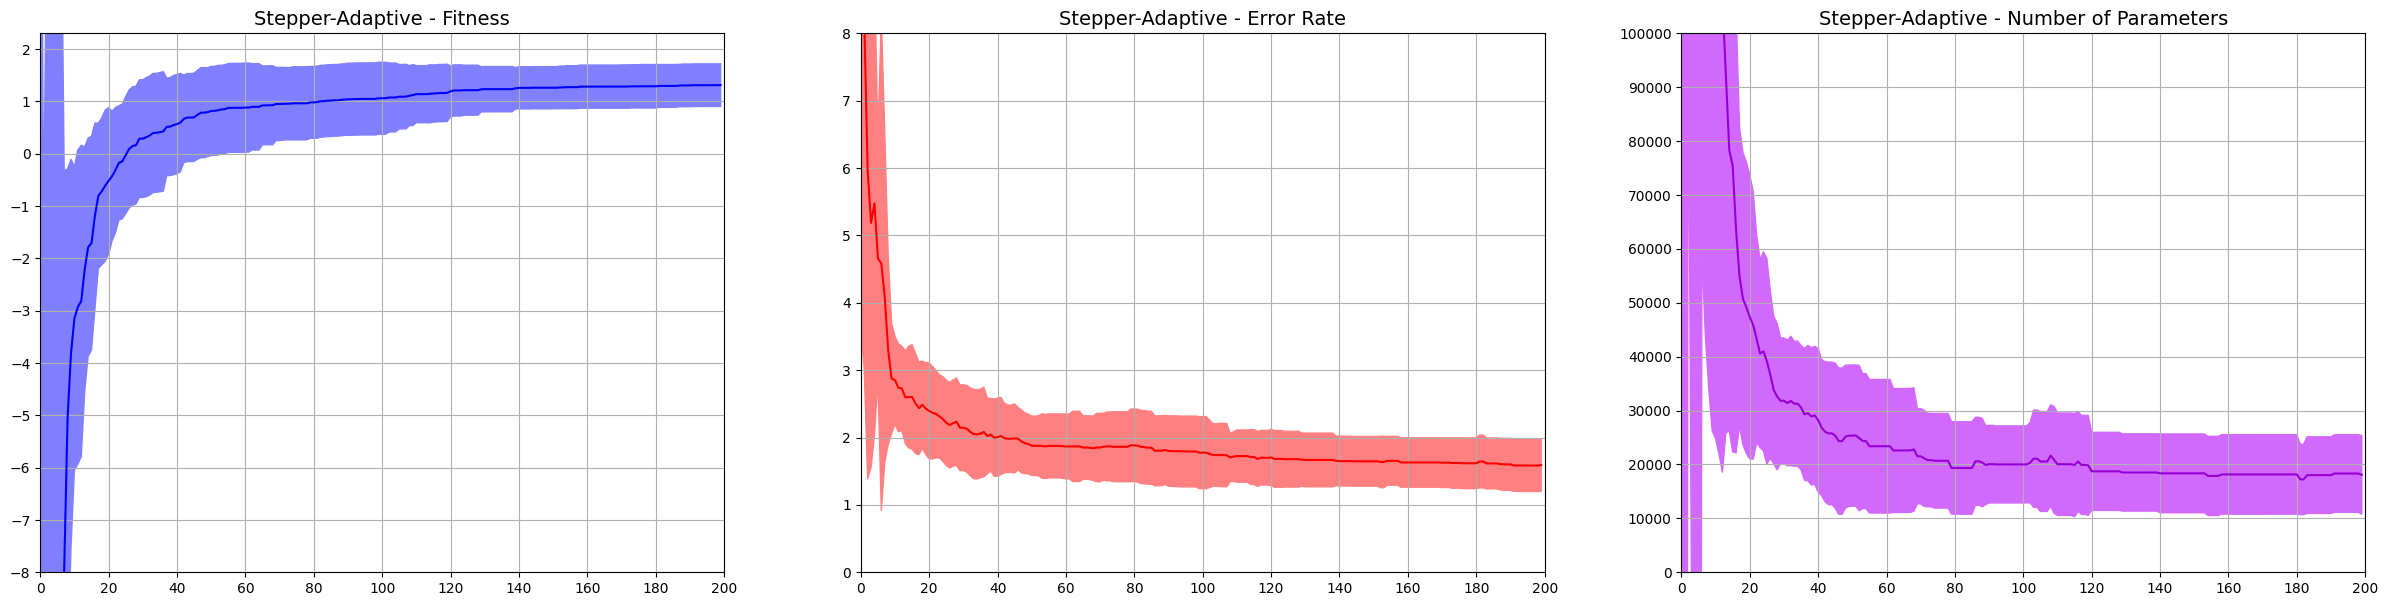

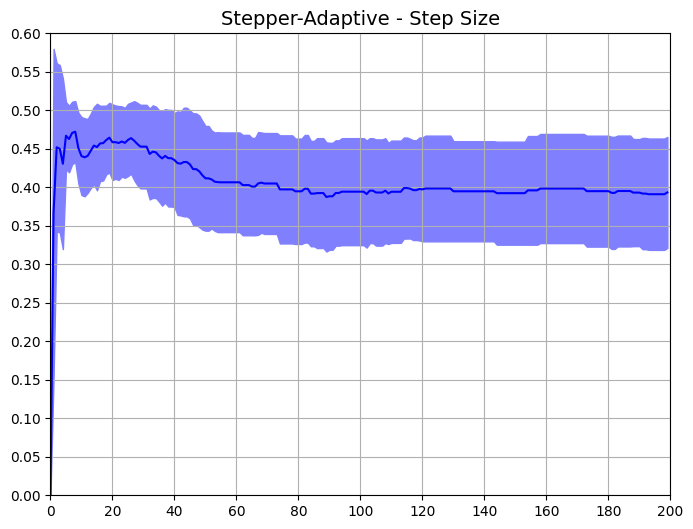

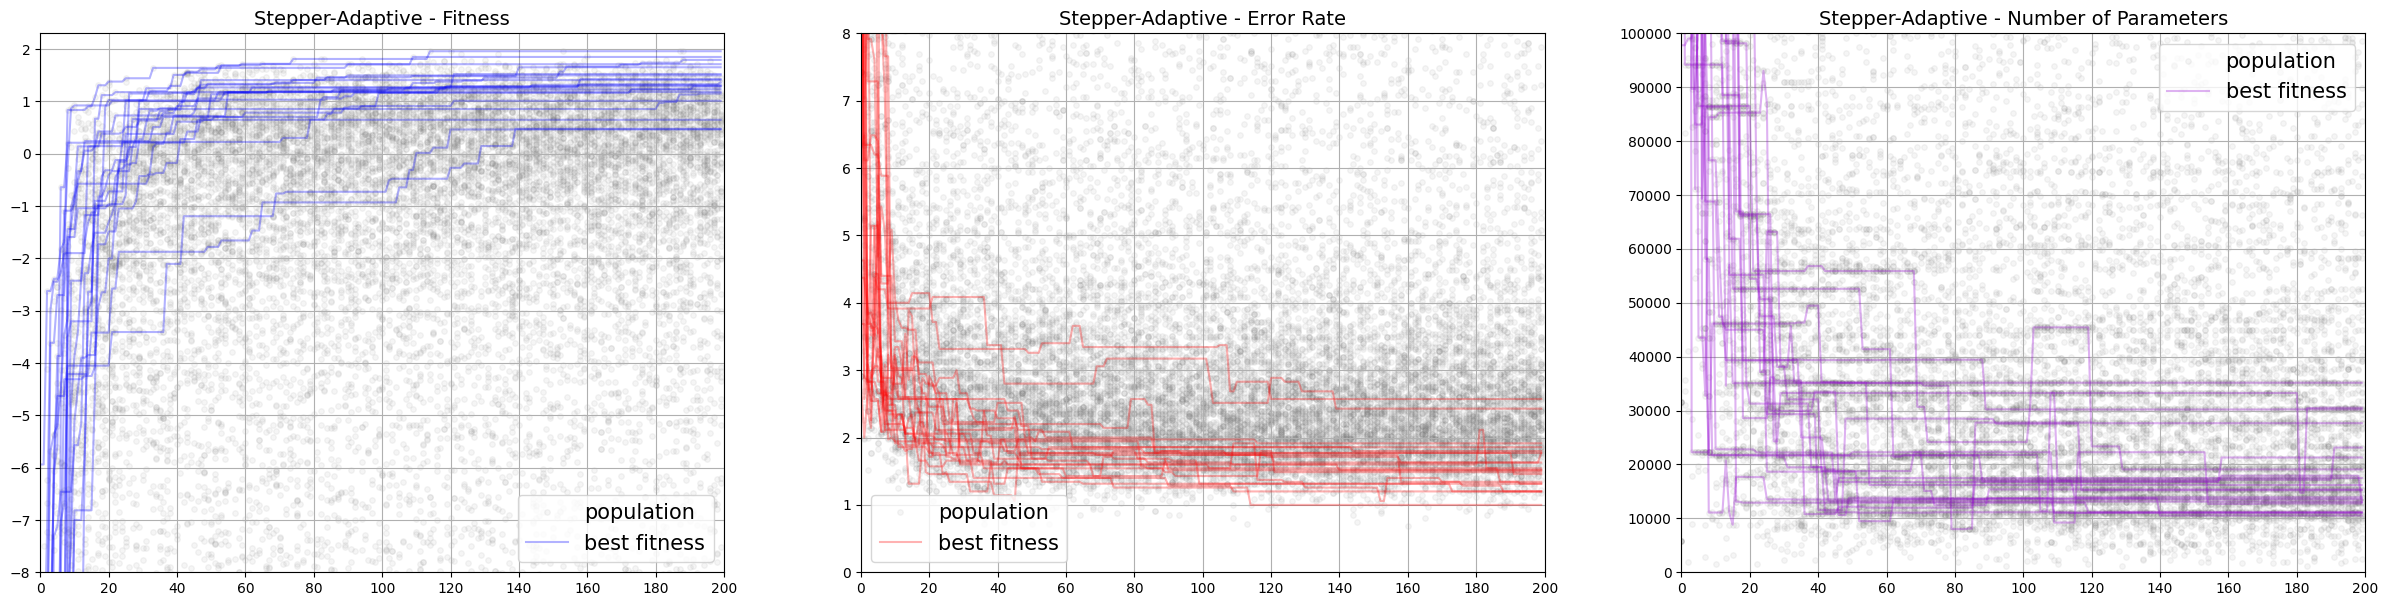

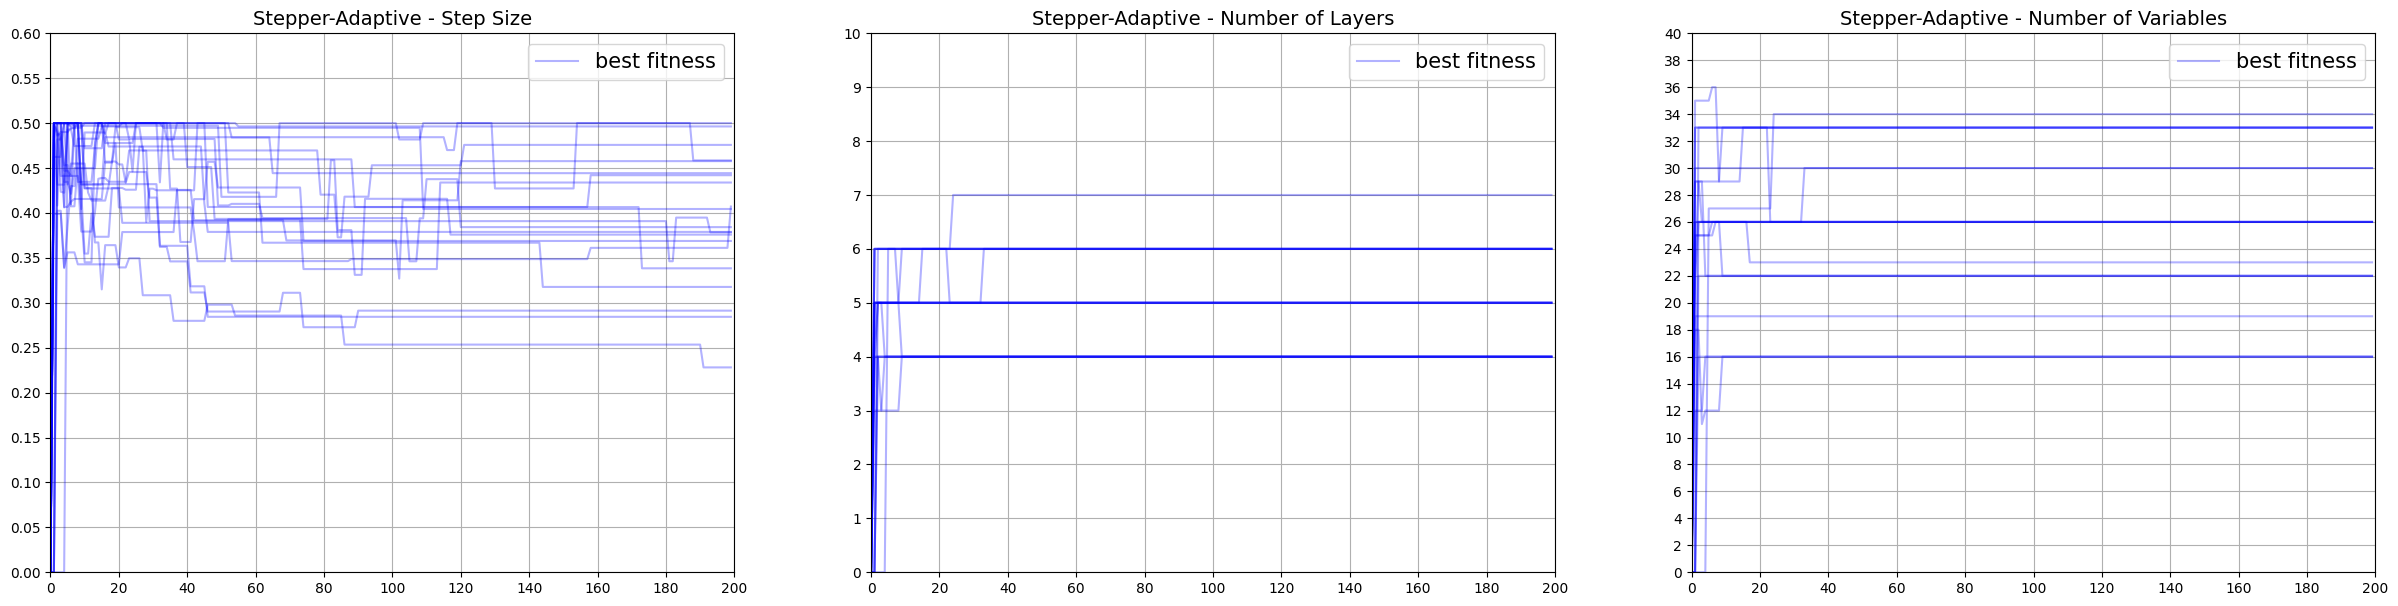

Plots for best run #14


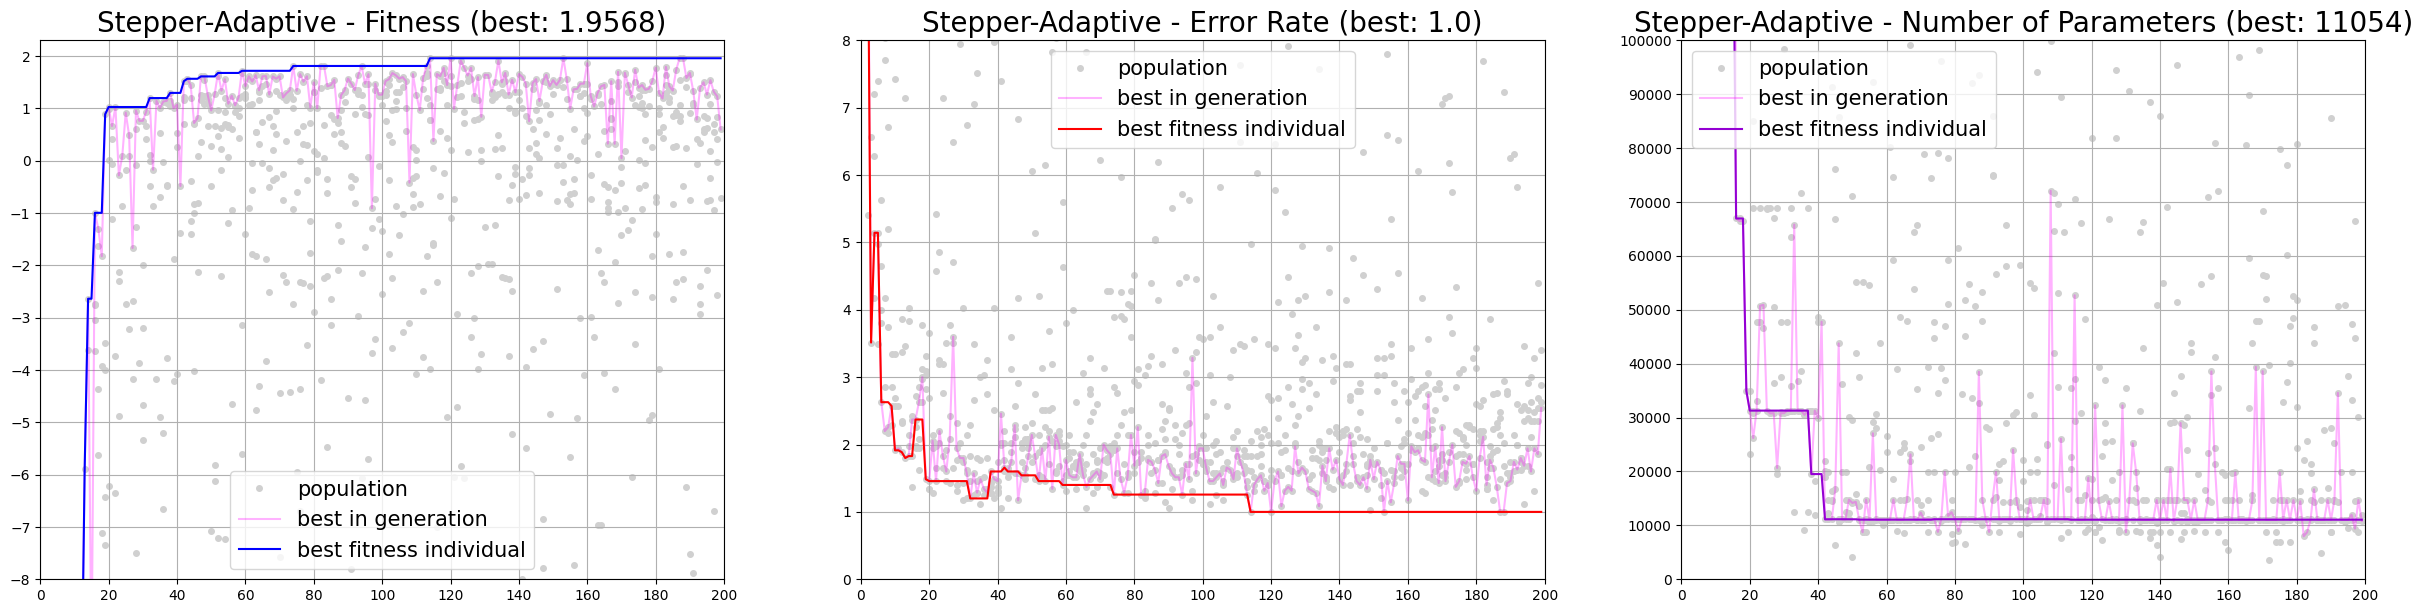

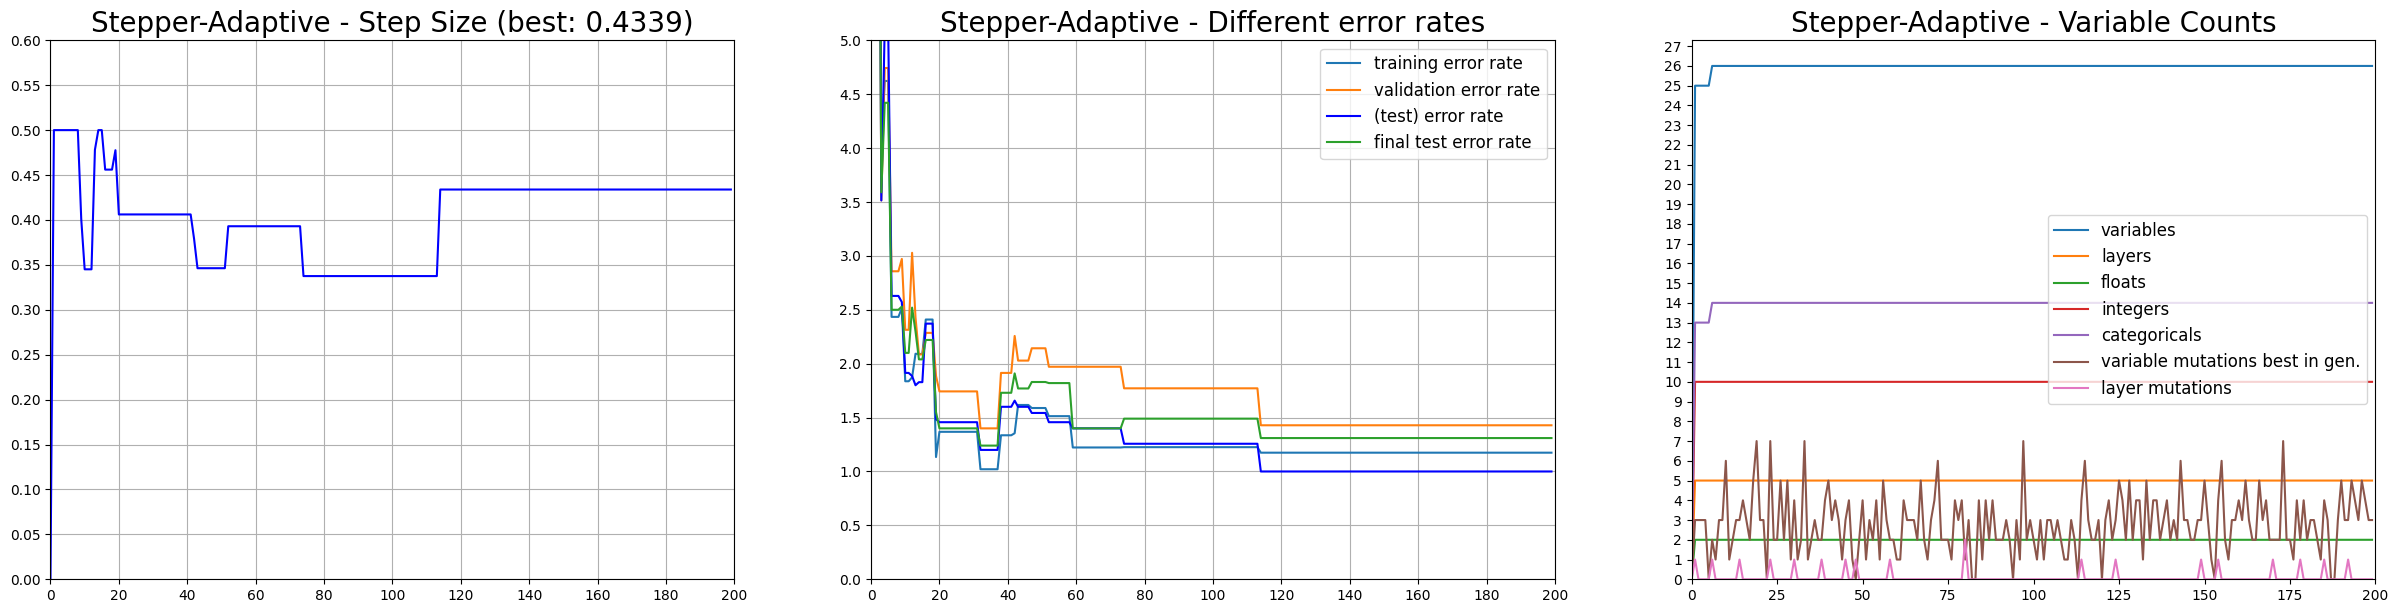

In [6]:
experiment_name = 'Stepper-Adaptive'
stats = load_stats(experiment_name, experiment_path)
print_statistics(stats, experiment_name)

do_all_plots(stats, experiment_name, plot_best_run=True, group_pictures=True)